<a href="https://colab.research.google.com/github/changsksu/K-State-IMSE641/blob/master/Non_Parametric_MCP_chat_GPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Sullivan-style nonparametric multiple change point detection (rank-based)
# using recursive binary segmentation with a Wilcoxon rank-sum (Mann–Whitney) statistic.
#
# Simulated dataset: 3 segments (2 change points), each segment has 30 observations,
# mean=10, std=2. (Same distribution across segments -> algorithm should generally
# NOT find true change points consistently; to demonstrate detection, change at least
# one segment mean. See the optional "DEMO" switch below.)

import numpy as np

In [12]:
# -----------------------------
# 1) Simulate data
# -----------------------------
rng = np.random.default_rng(7)

n_seg = 30
mu = 10
sigma = 2

# As you requested: all three segments have the same mean/std
x1 = rng.normal(mu, sigma, n_seg)
x2 = rng.normal(mu, sigma, n_seg)
x3 = rng.normal(mu, sigma, n_seg)
x = np.concatenate([x1, x2, x3])

# Optional: turn this ON if you want a clear detection demo
DEMO = True
if DEMO:
    x2 = rng.normal(mu + 4, sigma, n_seg)  # mean shift
    x3 = rng.normal(mu - 3, sigma, n_seg)  # another shift
    x = np.concatenate([x1, x2, x3])

# True change points for 3 equal segments (0-indexed boundaries)
true_cps = [n_seg-10, 2 * n_seg]  # i.e., after index 29 and after index 59
x

array([10.00246031, 10.59749108,  9.45172429,  8.21881632,  9.09065843,
        8.01670689, 10.12028721, 12.68043049,  9.01558696,  8.7590502 ,
       10.9796841 , 10.71377402, 10.2108285 ,  8.13906391,  9.94149636,
       11.39060639,  7.31157091,  9.08476848,  6.19755452,  7.42092452,
        6.31652992,  9.52981774,  7.46510704, 10.54252872, 10.31350217,
        9.62613811,  4.96648058,  8.92261421,  9.90299811, 10.22661797,
       13.95171277, 15.33676205, 13.3202609 , 16.10425272, 13.98920088,
       15.16676471, 11.41821351, 14.6933601 , 10.62359177,  9.92934211,
       13.39104624, 12.20014478, 14.32810559, 18.48951325, 12.33655364,
       12.75211283, 14.41080789, 14.98602658, 13.64718787, 13.58813934,
       15.40492591, 15.03981527, 11.93264834, 13.84163736, 14.0705737 ,
       11.89103076, 14.5196782 , 12.28408705, 15.94413342, 14.38549183,
        7.17861297,  5.81794329,  6.76278035,  3.00450741,  4.73718506,
        7.7256796 ,  2.74286592,  8.69321704,  3.50780705,  8.51

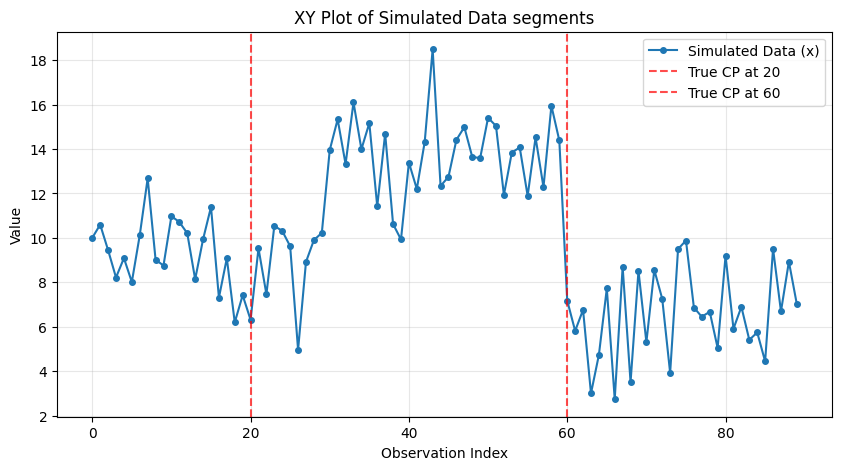

In [13]:
# Plot the simulated data set
import matplotlib.pyplot as plt

# 1) Setup the figure size
plt.figure(figsize=(10, 5))

# 2) Plot the array 'x'
plt.plot(x, marker='o', linestyle='-', markersize=4, label='Simulated Data (x)')

# 3) (Optional) Mark the true change points at indices 30 and 60
for cp in true_cps:
    plt.axvline(x=cp, color='red', linestyle='--', alpha=0.7, label=f'True CP at {cp}')

# 4) Add labels and title
plt.title('XY Plot of Simulated Data segments')
plt.xlabel('Observation Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)

# 5) Display the plot
plt.show()


In [9]:
# Funtions to execute the MCP algorithm
# -----------------------------
# 2) Helper: rank within a segment
# -----------------------------
def ranks_of_segment(values: np.ndarray) -> np.ndarray:
    """
    Return 1..n ranks with average ranks for ties (simple tie handling).
    Uses a stable method without scipy.
    """
    n = len(values)
    order = np.argsort(values, kind="mergesort")
    ranks = np.empty(n, dtype=float)
    sorted_vals = values[order]

    i = 0
    while i < n:
        j = i
        while j + 1 < n and sorted_vals[j + 1] == sorted_vals[i]:
            j += 1
        # average rank for ties; ranks are 1-based
        avg_rank = (i + 1 + j + 1) / 2.0
        ranks[order[i : j + 1]] = avg_rank
        i = j + 1

    return ranks

# -----------------------------
# 3) Single-split Sullivan statistic (standardized Wilcoxon rank-sum)
# -----------------------------
def best_split_statistic(values: np.ndarray, min_size: int = 5):
    """
    For a segment 'values' of length n, compute:
      Z(k) = [W(k) - k(n+1)/2] / sqrt(k(n-k)(n+1)/12)
    where W(k) is the sum of ranks of the first k observations (within this segment).
    Returns (best_k, best_abs_z, z_at_best_k) where best_k is the split location
    (number of points in left group).
    """
    n = len(values)
    if n < 2 * min_size:
        return None, 0.0, 0.0

    r = ranks_of_segment(values)  # ranks within this segment
    prefix = np.cumsum(r)

    best_k = None
    best_abs = 0.0
    best_z = 0.0

    for k in range(min_size, n - min_size + 1):
        Wk = prefix[k - 1]
        Ew = k * (n + 1) / 2.0
        Vw = k * (n - k) * (n + 1) / 12.0
        if Vw <= 0:
            continue
        z = (Wk - Ew) / np.sqrt(Vw)
        az = abs(z)
        if az > best_abs:
            best_abs = az
            best_k = k
            best_z = z

    return best_k, best_abs, best_z

# -----------------------------
# 4) Multiple change points via recursive binary segmentation
# -----------------------------
def sullivan_mcp(values: np.ndarray, alpha: float = 0.01, min_size: int = 5, max_cps: int = 10):
    """
    Sullivan-style nonparametric MCP:
    - For each current segment, find best split maximizing |Z(k)|
    - If max |Z| exceeds threshold, accept split and recurse on the two subsegments
    - Stop when no segment has a significant split or max_cps reached

    Threshold: uses a simple normal approximation with Bonferroni-ish adjustment.
    For teaching/demo, this is fine; in research you’d usually calibrate with
    permutation/bootstrapping or known asymptotics for max over k.
    """
    n = len(values)

    # Normal approx critical value; conservative for multiple testing
    # You can tune this. Smaller alpha => fewer false positives.
    from math import erf, sqrt

    def norm_ppf(p):
        # Approx inverse CDF for standard normal (Acklam-like approximation not used);
        # We'll do a binary search on erf-based CDF to keep dependencies minimal.
        # CDF(z) = 0.5*(1 + erf(z/sqrt(2)))
        lo, hi = -10.0, 10.0
        for _ in range(80):
            mid = (lo + hi) / 2
            cdf = 0.5 * (1.0 + erf(mid / sqrt(2.0)))
            if cdf < p:
                lo = mid
            else:
                hi = mid
        return (lo + hi) / 2

    # Two-sided -> alpha/2; also adjust by n to be conservative over many k checks
    # (not exact, but works as a guardrail).
    crit = norm_ppf(1.0 - (alpha / (2.0 * max(n, 1))))

    # segments stored as (start, end) half-open intervals in the original array
    segments = [(0, n)]
    change_points = []

    # Iterate: always split the segment that currently has the largest |Z|
    while True and len(change_points) < max_cps:
        best = None  # (abs_z, start, end, split_k, z)
        for (s, e) in segments:
            seg = values[s:e]
            k, abs_z, z = best_split_statistic(seg, min_size=min_size)
            if k is None:
                continue
            if best is None or abs_z > best[0]:
                best = (abs_z, s, e, k, z)

        if best is None:
            break

        abs_z, s, e, k, z = best
        if abs_z <= crit:
            break

        cp = s + k  # change point in original indexing (split between cp-1 and cp)
        change_points.append(cp)

        # replace (s,e) with (s,cp) and (cp,e)
        segments.remove((s, e))
        segments.append((s, cp))
        segments.append((cp, e))

        # keep segments ordered (not necessary, but cleaner)
        segments.sort()

    change_points.sort()
    return change_points, crit

In [14]:
# -----------------------------
# 5) Run detection + print results
# -----------------------------
cps, crit = sullivan_mcp(x, alpha=0.01, min_size=8, max_cps=5)

print("True change points (boundaries between segments):", true_cps)
print("Detected change points:", cps)
print("Critical |Z| threshold used:", crit)
print("DEMO mode:", DEMO)

True change points (boundaries between segments): [20, 60]
Detected change points: [30, 60]
Critical |Z| threshold used: 3.8649518622769214
DEMO mode: True


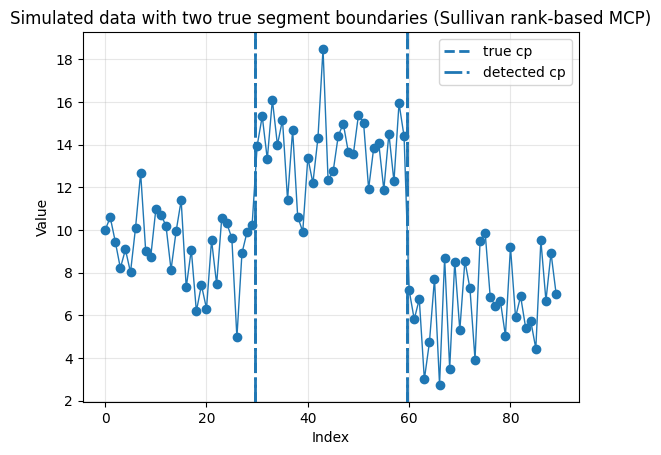

In [11]:
# -----------------------------
# 6) (Optional) quick plot
# -----------------------------
try:
    import matplotlib.pyplot as plt

    plt.figure()
    plt.plot(np.arange(len(x)), x, marker="o", linewidth=1)
    for cp in true_cps:
        plt.axvline(cp - 0.5, linestyle="--", linewidth=2, label="true cp" if cp == true_cps[0] else None)
    for cp in cps:
        plt.axvline(cp - 0.5, linestyle="-.", linewidth=2, label="detected cp" if cp == cps[0] else None)

    plt.title("Simulated data with two true segment boundaries (Sullivan rank-based MCP)")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
except Exception as ex:
    print("Plot skipped:", ex)